# Parameterization Experiments

In this notebook, we'll illustrate the process of learning a *parameterized* form for $\Omega$ from data with true labels. 

In [1]:
using StatsBase
using Combinatorics
using Plots
using Optim

include("jl/omega.jl")
include("jl/HSBM.jl")
include("jl/read_data.jl")
include("jl/inference.jl")
include("jl/objectives.jl");

# Parameterization

So the below code is VERY shaggy, but here's what we're doing. We're going to let 
$$\Omega(\mathbf{p};\alpha, \beta) = \left(\frac{p_1}{k}\right)^{\alpha_k} n^{\beta_k k}\;,$$
where $\alpha$ and $\beta$ are parameters and $k = \mathbf{e}^T\mathbf{p}$. (in the code below, $\alpha$ is the first half of the parameter vector and $\beta$ is the second half). We are assuming that $\mathbf{p}$ is sorted so that $p_1$ is the size of the largest subgroup (or plurality). Intuitively, $\alpha_k$ is controlling homogeneity preference: if $\alpha_k$ is large, then most hyperedges will have the vast majority of nodes in a single group label.  $\beta_k$ is controlling the number of edges of size $k$. I've chosen the scaling so that if $\beta_k$ is larger than 1 then that should reflect fewer edges at that specific size, although one could definitely do this differently. 

The below code defines a function to read data and optimize these parameters, then plots it. 

In [377]:
function plotα(dataset, kmax_)
    H, Z = read_hypergraph_data(dataset,kmax_)
    
    if haskey(H.E, 1) delete!(H.E, 1) end
    v = sort(collect(keys(H.E)))
    
    kmax = maximum(v)
    
    K_map = Dict(v[i] => i for i in 1:length(v))
    
    lk = length(K_map)
    α0 = vcat(1 .+ rand(kmax),  0.25.+0.5*rand(kmax))
    
    n = 1*length(H.D)
    
    function ω(p, α, K_map)
        k_ = sum(p)
        if haskey(K_map, k_) 
            k = K_map[k_]
#             return (p[1] / k_)^α[k]  / n^(α[lk+k]*k_)
#             return sum((p .* (1:length(p)))/k_)^(-α[k]) / n^(α[lk+k]*k_)
            return sum(p)/sum((p .* (1:length(p)).^α[k])) / n^(α[lk+k]*k_)
        else
            return 1
        end
    end
    
    Ω = buildΩ((p, α) -> ω(p,α,K_map), α0, kmax);
    
    ℓ = maximum(k for k in keys(H.E)) # size of largest hyperedge

    C       = evalCuts(Z,H)
    V, μ, S = evalSums(Z,H,ℓ,true);

    α = α0
    res = 0
    
    function objective(a, ix)
        alph = copy(α)
        alph[ix] = a[1]
        obj = 0.0
        for p in keys(S)
            Op = Ω(p; α=alph, mode="partition")
            obj -= S[p]*Op
            if p in keys(C)
                obj += C[p]*log(Op)
            end
        end
        return -obj # for minimization
    end
    
    for i = 1:20
        for h in 1:lk
            res = optimize(a -> objective(a, h+lk), 0.0, 3.0)
            α[h+lk] = Optim.minimizer(res)[1]
            
            res = optimize(a -> objective(a, h), 0, 50)
            α[h] = Optim.minimizer(res)[1]
        end

#         println(α)
    end
    
    print(rpad("$dataset", 25, " "))
    print(" LL : ")
    println(round(convert(Float64, -Optim.minimum(res)[1]), digits = 3))
    
    p1 = plot(v, α[1:lk], seriestype = :scatter, label="", title = dataset)
    ylabel!("α")
    ylims!((0, 1.1*maximum(α[1:lk])))
    p2 = plot(v, α[(lk+1):(2*lk)], seriestype = :scatter, label="", color = "orange")
    ylabel!("β")
    xlabel!("k")
    ylims!((0,2))
    
    l = @layout [a ; b]
    
    return plot(p1, p2, layout = l)
    
end

plotα (generic function with 1 method)

In [391]:
# note: this computation slows down significantly for large kmax

kmax = 25

p1 = plotα("TrivagoClickout",        kmax)
p2 = plotα("walmart-trips",          kmax)
p3 = plotα("congress-bills",         kmax)
p4 = plotα("contact-primary-school", kmax);

TrivagoClickout           LL : -1.98231408287206e11
walmart-trips             LL : -5.808142489e6
congress-bills            LL : -9.967120569e6
contact-primary-school    LL : -199811.245


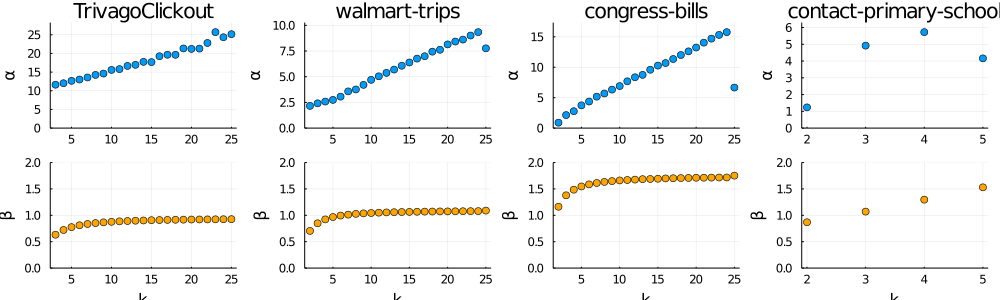

In [392]:
l = @layout [a b c d]
P2 = plot(p1, p2, p3, p4, layout = l, size = (1000, 300))

It is possible that the algorithm terminated before we got around to reasonably optimizing the value for $k = 25$, further investigation is necessary here. Probably a good time to do something more formal with gradients. Maybe alternating gradient descent between the size parameter and the partition parameter. 